In [1]:
from skimage.io import imread
from skimage.filters import median
from skimage.morphology import disk
from sklearn.mixture import GaussianMixture

import cv2

import numpy as np
import matplotlib.pyplot as plt
import maxflow

In [2]:
imgs = imread('../data/nerves_part.tiff')
imgs = imgs.astype(float) / 255

In [3]:
I_orig = imgs[500]

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]

### Thresholding

In [162]:
I = median(I_orig, disk(5))  # elipse
f = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
I = cv2.filter2D(I, -1, f)   # sharpener

In [163]:
S = np.where(I > 0.4, 1, 0)

Text(0.5, 1.0, 'Segmented image')

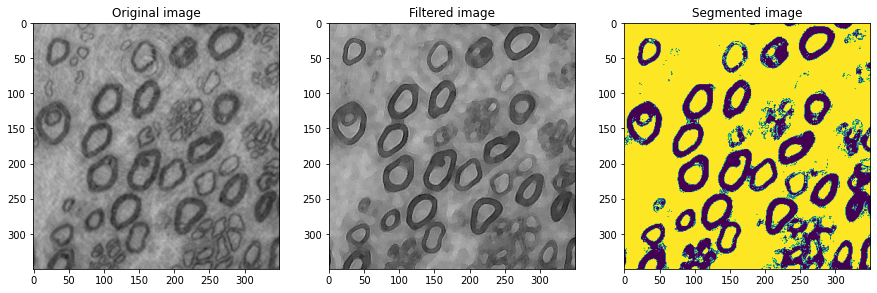

In [164]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(I_orig, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(I, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[1].set_title('Filtered image')
ax[2].imshow(S)
ax[2].set_title('Segmented image')

### MRF

In [5]:
def mrf(I, mu, beta):
    g = maxflow.Graph[float]()
    nodeids = g.add_grid_nodes(I.shape)
    g.add_grid_edges(nodeids, beta)
    g.add_grid_tedges(nodeids, (I-mu[1])**2, (I-mu[0])**2)

    g.maxflow()
    return g.get_grid_segments(nodeids)


def estimate_mu(img):
    img = img.ravel()
    gm = GaussianMixture(n_components=2, random_state=0)
    gm.fit(img[:, np.newaxis])
    return list(gm.means_.T[0])


def process_img(img):
    I = median(img, disk(5))  # disk = elipse
    f = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    I = cv2.filter2D(I, -1, f)   # sharpener
    return I

In [12]:
img = imgs[200]

I = process_img(img)
mu = estimate_mu(I)
I_seg = mrf(I, mu, beta=0.01)

Text(0.5, 1.0, 'Segmented image')

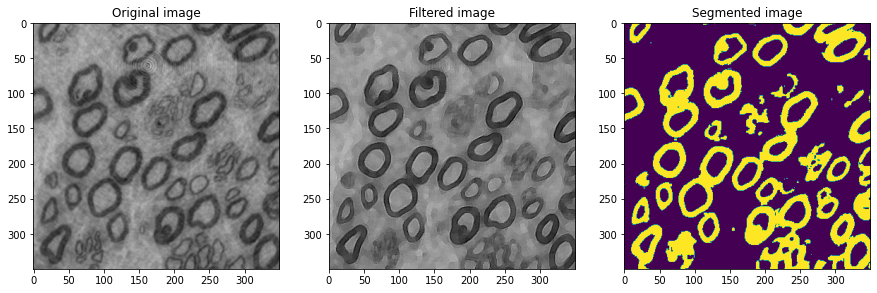

In [13]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(img, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(I, vmin=0, vmax=1, cmap=plt.cm.gray)
ax[1].set_title('Filtered image')
ax[2].imshow(I_seg)
ax[2].set_title('Segmented image')

In [11]:
try:
    for img in imgs:
        I = process_img(img)
        mu = estimate_mu(I)
        I_seg = mrf(I, mu, beta=0.01)
        cv2.imshow('image', I_seg.astype(np.float32))
        cv2.waitKey(20)
except KeyboardInterrupt:
    cv2.destroyAllWindows()

### Chan-Vese